In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [24]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    nA = env.action_space.n
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, nA)
    
    for i_episode in range(num_episodes)  :
        
        epsilon /= (i_episode + 1)
        
        # Print out which episode we're on, useful for debugging.
        if ((i_episode + 1) % 100 == 0):
            print("Episode {}/{}.".format(i_episode + 1, num_episodes))
            sys.stdout.flush()
        
        state = env.reset()
        terminated = False
        
        for t in itertools.count():
            
            # sample the action from the epsilon greedy policy
            action = np.random.choice(nA, p=policy(state))
            
            # Perform the action -> Get the reward and observe the next state
            new_state, reward, terminated, _ = env.step(action)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # value that we should have got
            # The Q-learning target policy is a greedy one, hence the `max`
            td_target = reward + discount_factor * max(Q[new_state])
            td_error = td_target - Q[state][action]
            
            # Q-learning update
            Q[state][action] += alpha * td_error
            
            # update current state
            state = new_state
            
            if terminated:
                break
    
    return Q, stats

In [25]:
Q, stats = q_learning(env, 500)

Episode 100/500.
Episode 200/500.
Episode 300/500.
Episode 400/500.
Episode 500/500.


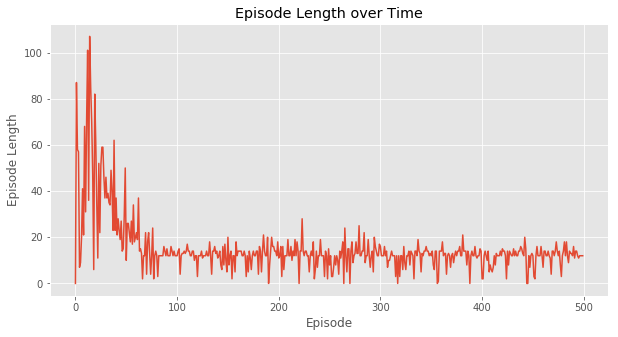

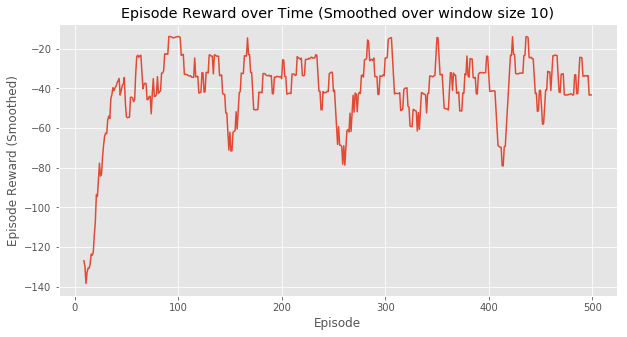

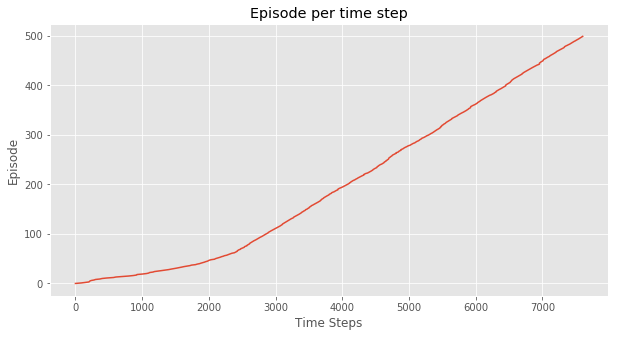

(<matplotlib.figure.Figure at 0x7fae4dd95150>,
 <matplotlib.figure.Figure at 0x7fae4bab8c10>)

In [26]:
plotting.plot_episode_stats(stats)